In [1]:
# Basics Importation 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

# For Detailed Stats Output
import statsmodels.api as sm
# The linear regression models 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV, ElasticNetCV, LogisticRegression
# Instantiating the linear regression models
ols = LinearRegression()
ridge = Ridge()
lasso  = Lasso()
lassocv = LassoCV()
elasticnet = ElasticNet()
elasticnetcv = ElasticNetCV()
# The tree model
from sklearn import tree
# Instantiating the tree model (regression type)
regressor = tree.DecisionTreeRegressor()
# The ensemble model for random forest and bagging
from sklearn import ensemble
# Instantiating the ensemble models
randomForest = ensemble.RandomForestRegressor()
bagging      = ensemble.BaggingRegressor()
# Instantiating the boost models
gbm          = ensemble.GradientBoostingRegressor()
abr          = ensemble.AdaBoostRegressor()
# xg boost
import xgboost as xgb
# lg boost
import lightgbm as lgb
# K mean clustering
from sklearn.cluster import KMeans
kmeans = KMeans()
# The model selection for cross validation, k fold splits, train_test_split, grid search etc. 
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# Some automatic feature selection functions (recursive finding, best feature selection etc.)
import sklearn.feature_selection as fs
# Importing the different error evaluation/metrics
from sklearn import metrics
from sklearn.metrics import silhouette_score

# Making it so that we can see all columns of the dataframe
pd.set_option('display.max_columns', None)

# Import data
df_train=pd.read_csv('df_train_cleaned.csv',index_col='Id')
df_test=pd.read_csv('df_test_cleaned.csv',index_col='Id')
df_total=pd.read_csv('df_total_cleaned.csv',index_col='Id')
df=df_total

dum_df_train=pd.read_csv('standardized_dummified_df_train.csv',index_col='Id')
dum_df_test=pd.read_csv('standardized_dummified_df_test.csv',index_col='Id')
dum_df_total=pd.read_csv('standardized_dummified_df_total.csv',index_col='Id')
dum_df=dum_df_train

In [2]:
nominal_var_processed=['MSZoning','Street','Alley','LotShape','LandContour','LotConfig','LandSlope',\
             'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl',\
             'Exterior1st','Exterior2nd','MasVnrType','Foundation',\
             'BsmtFinType1','Heating','CentralAir',\
             'Electrical','Functional','GarageType','GarageFinish',\
             'PavedDrive','Fence','MiscFeature','SaleType','SaleCondition','MSSubClass',\
             'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MoSold']
ordinal_var_processed=['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath',\
             'HalfBath','BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars',\
             'YrSold','HeatingQC','KitchenQual','ExterQual','ExterCond','BsmtQual',\
             'BsmtCond','BsmtExposure','FireplaceQu','GarageQual','GarageCond']
cont_var_processed=['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF',\
          '1stFlrSF','2ndFlrSF','GrLivArea','GarageYrBlt','GarageArea']
cont_var_for_tuning=ordinal_var_processed+cont_var_processed

In [3]:
def dummify_column(dataframe,column_name):
    '''
    ### NOTE!!! ### vector operation not working yet!!!! ###
    - dataframe takes the entire dataframe you are working on
    - column_name takes a list of strings, where the strings are the column names
    '''
    for feature in column_name:
        dummified_feature = pd.get_dummies(dataframe.loc[:,feature], prefix=feature, prefix_sep='__',drop_first=True)
        dummified_df = pd.concat([dataframe.drop(feature,axis=1),dummified_feature],axis=1,sort='False')
    return dummified_df

In [4]:
def undummify(dataframe):
    tot_col=dataframe.columns
    cat_col=list(tot_col[tot_col.str.contains('__')])
    cat_col_split=set(map(lambda x:x.split('__')[0],cat_col))
    cat_dict={}
    for col in cat_col_split:
        sub_df=dataframe[cat_col].loc[:,list(map(lambda x:col in x, dataframe[cat_col].columns))]
        for i in sub_df.columns:
            label_num=int(i.split('__')[1])
            sub_df.loc[:,i]=np.array(sub_df.loc[:,i])*label_num
        cat_dict[col]=sub_df.sum(axis=1)+1
    df1=dataframe.drop(cat_col,axis=1)
    df2=pd.DataFrame(cat_dict)
    return pd.concat([df1,df2],axis=1)

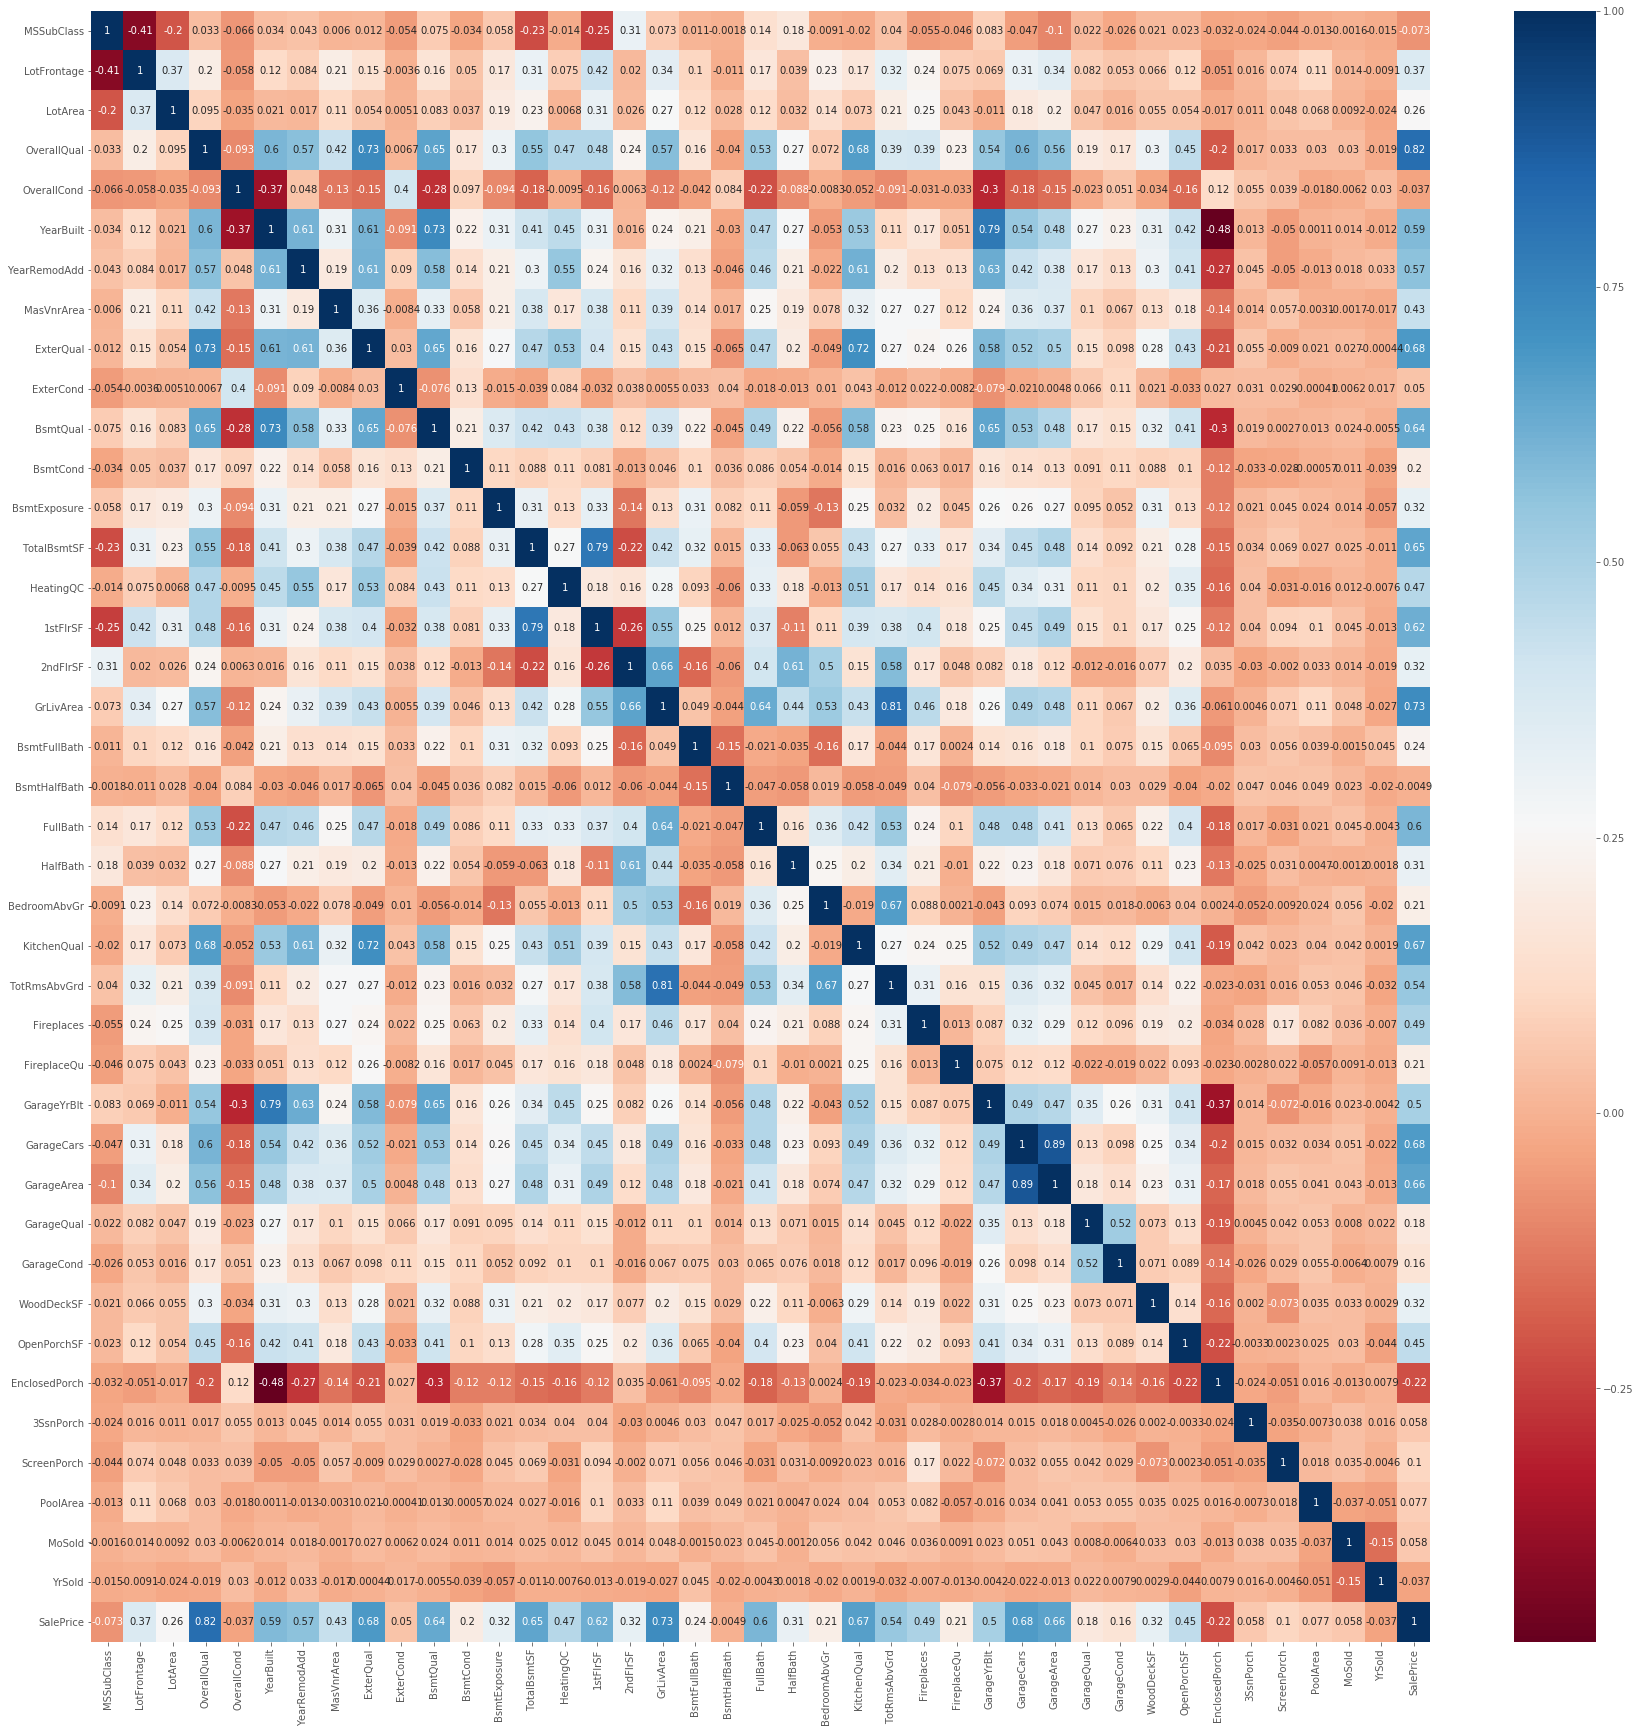

In [5]:
corr = df.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdBu", annot = True);


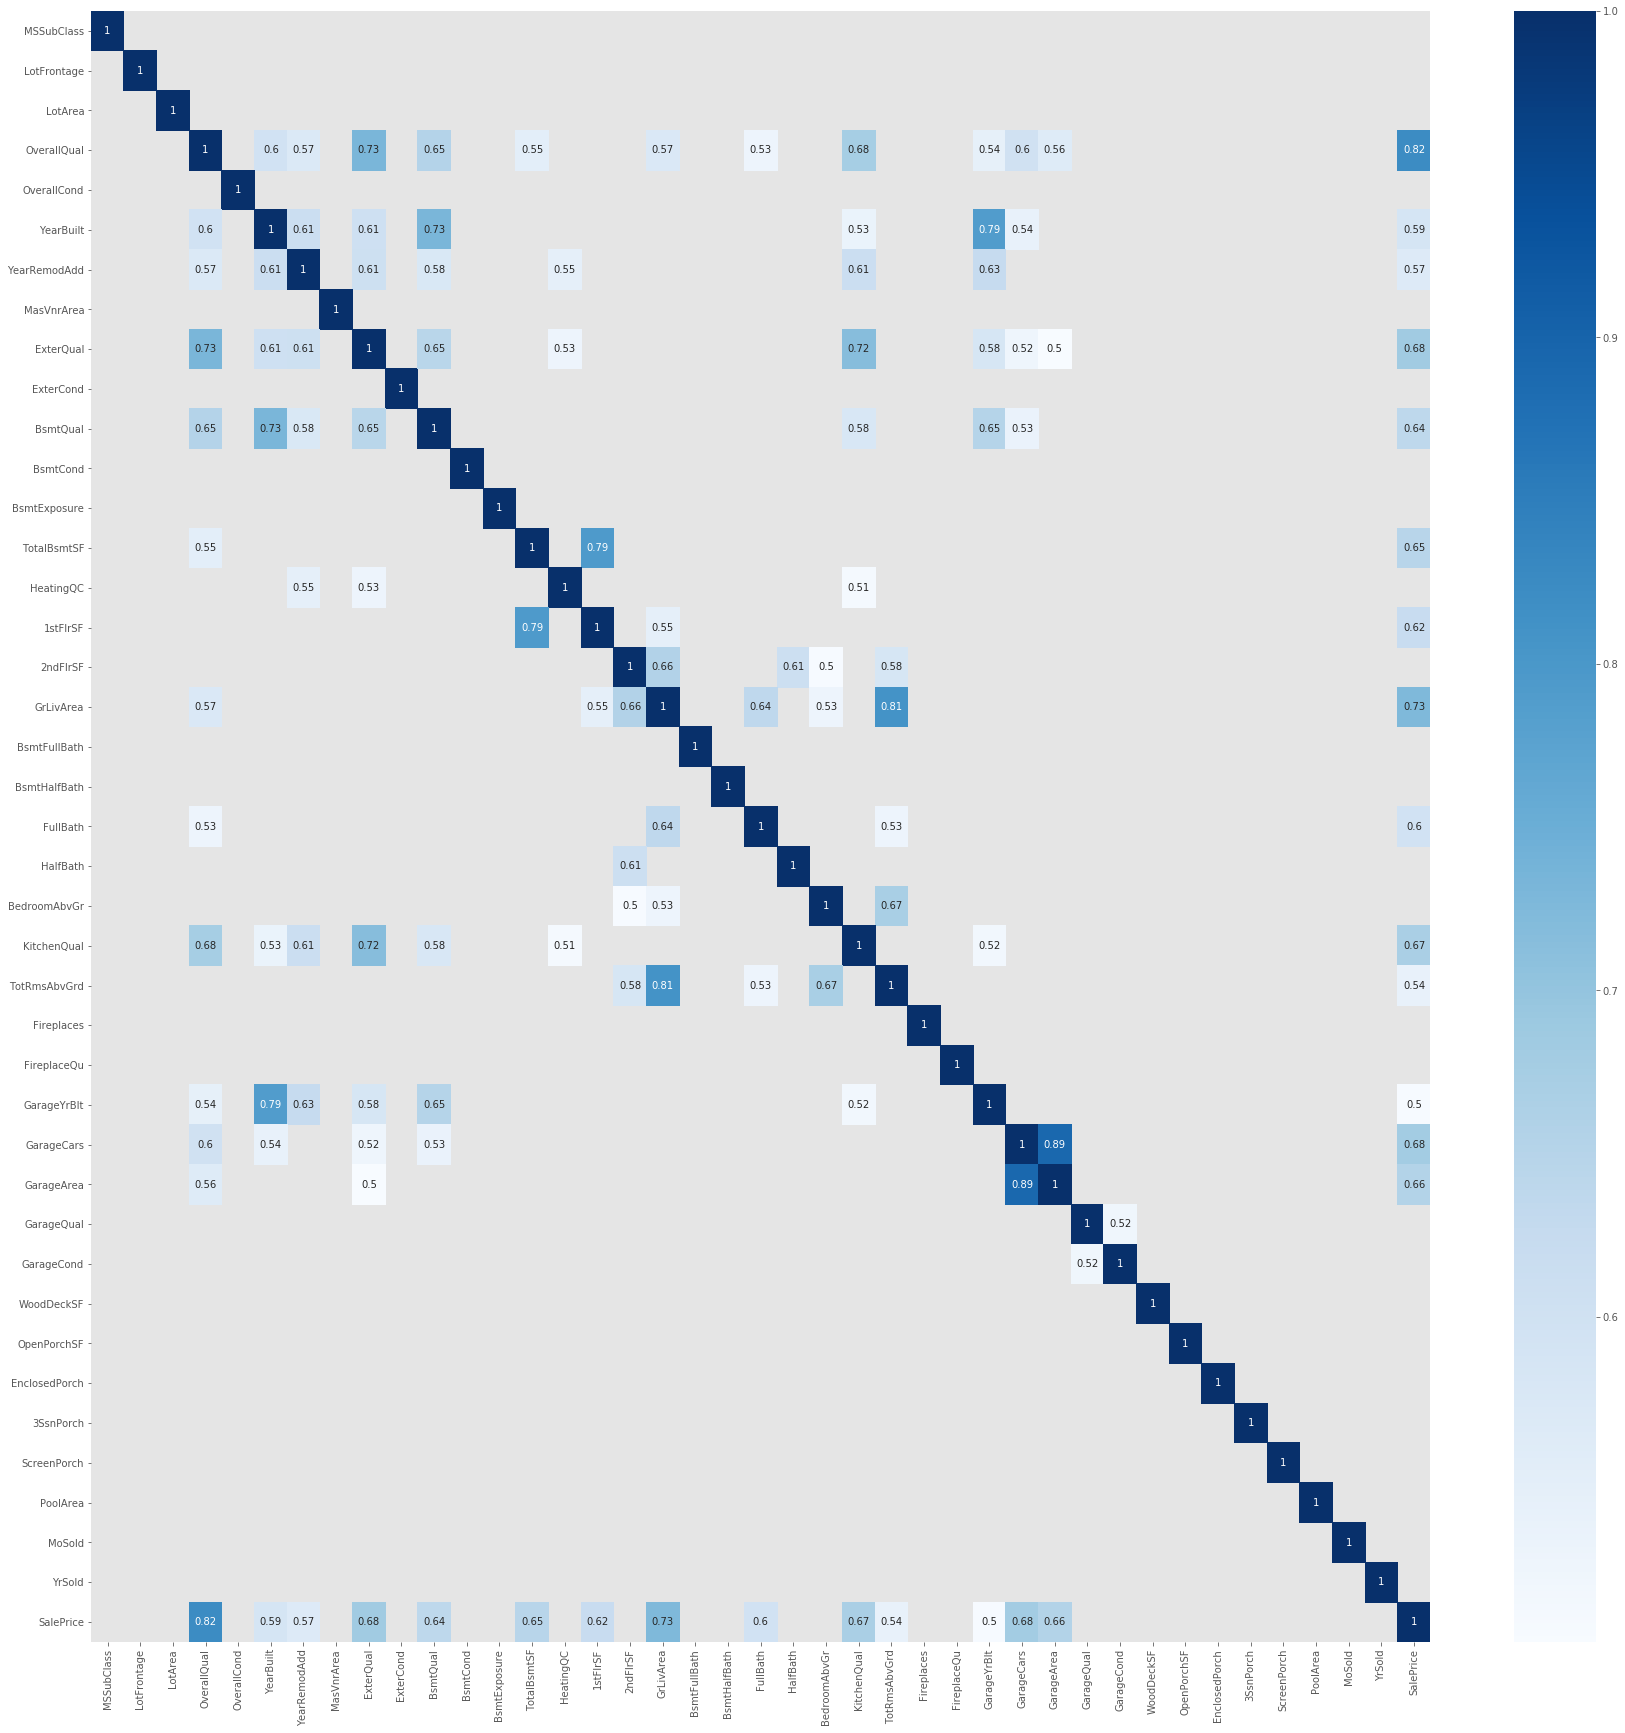

In [6]:
big_corr=corr[abs(corr)>0.5]
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(big_corr, cmap="Blues", annot = True);

In [7]:
x=dum_df.drop('SalePrice',axis=1)
y=dum_df.SalePrice

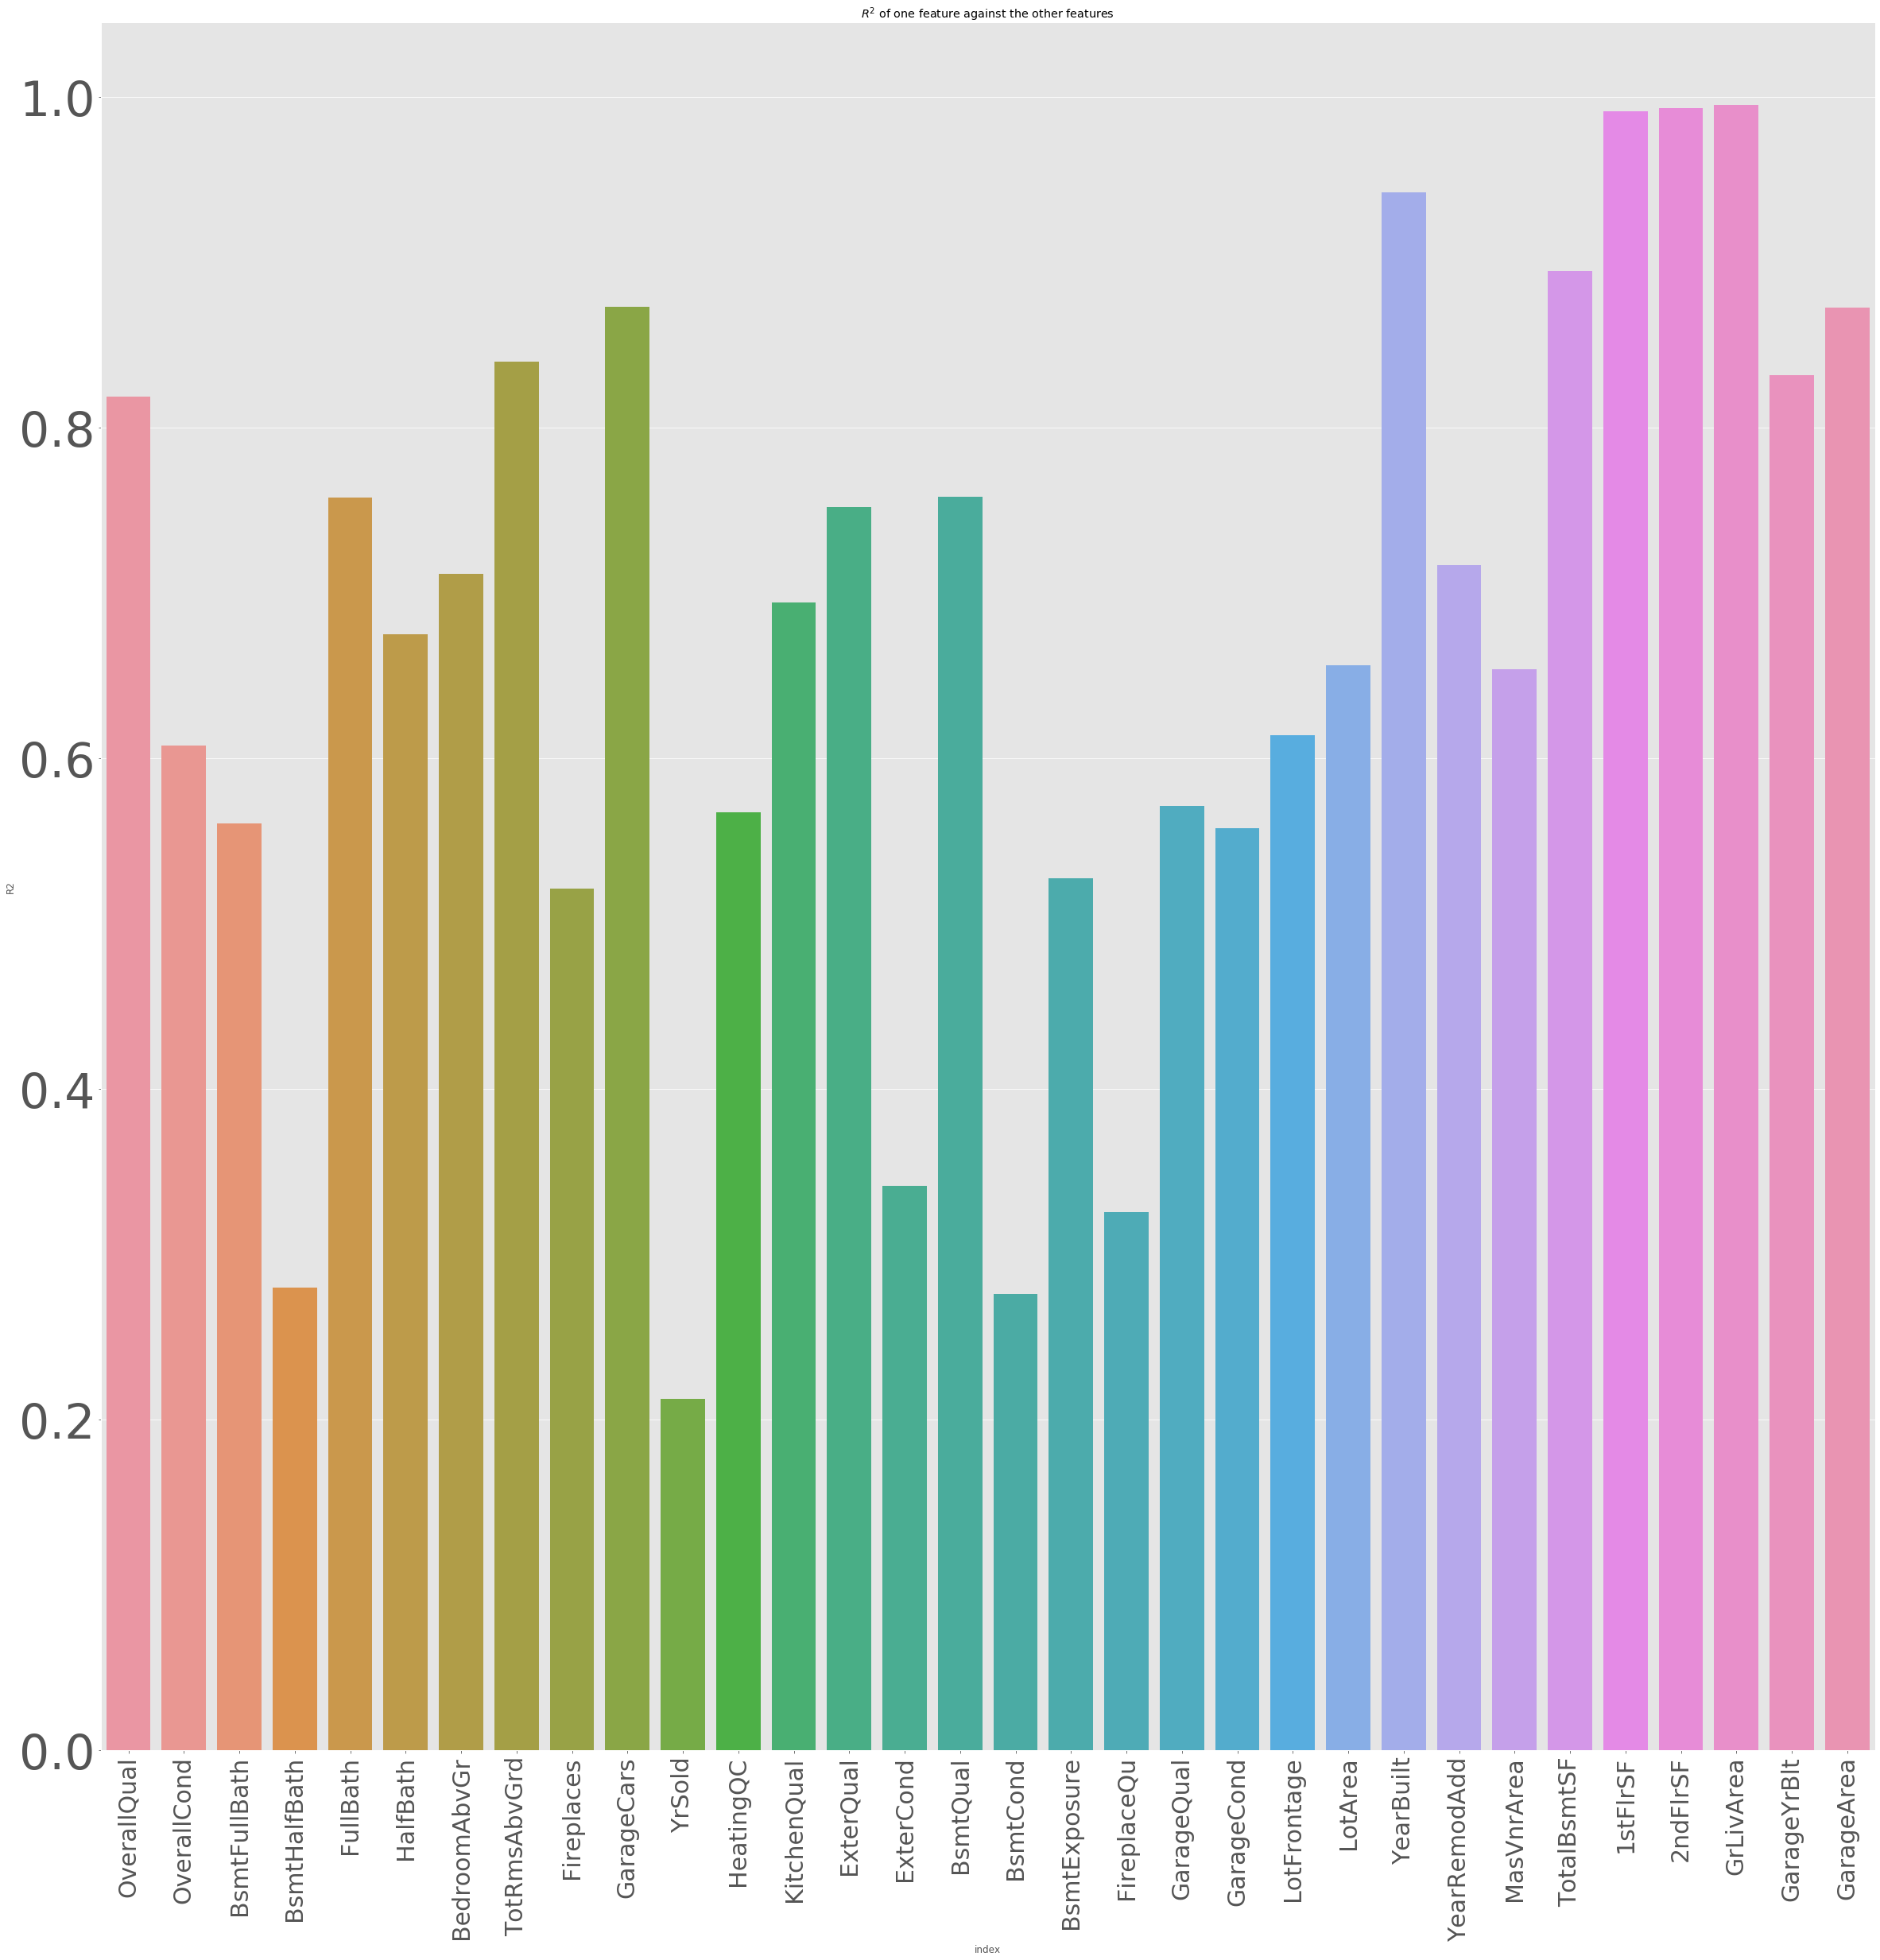

In [8]:
# R^2 score comparisons among continuous features against all other (continuous and categorical)
# High R^2 means collinearity exists between the features
# Continuous features vs continuous,ordinal,nominal variables
scores = {}
ols = LinearRegression()
for feature in cont_var_for_tuning:
                x_copy = x.copy()
                feature_col = x_copy[feature].copy()
                x_copy.drop(feature, axis=1, inplace=True)
                ols.fit(x_copy, feature_col)
                scores[feature] = ols.score(x_copy, feature_col)   
plt.figure(figsize=(40,40))
ax=sns.barplot(x='index', y='R2', data=pd.DataFrame(scores, index=['R2']).T.reset_index())
plt.title('$R^2$ of one feature against the other features');
plt.xticks(rotation=90);
plt.yticks(size=60);
plt.xticks(size=30);
# use R^2=0.4 and 0.8 as a cutoff. Below 0.4 is acceptable. Above 0.8 is unacceptable

In [9]:
# Categorizing the categorical variables
cat_df=df_train.copy()
cat_cols=set(df_train.columns[~df_train.columns.isin(cont_var_for_tuning)])-set('SalePrice')
for col in cat_cols:
    uniqueitemlist_=cat_df.loc[:,col].unique()
    number_length=uniqueitemlist_.shape[0]
    cat_dict={item:ind for ind,item in enumerate(uniqueitemlist_)}
    cat_df.loc[:,col]=cat_df.loc[:,col].replace(cat_dict)

/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/auscheng/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the num

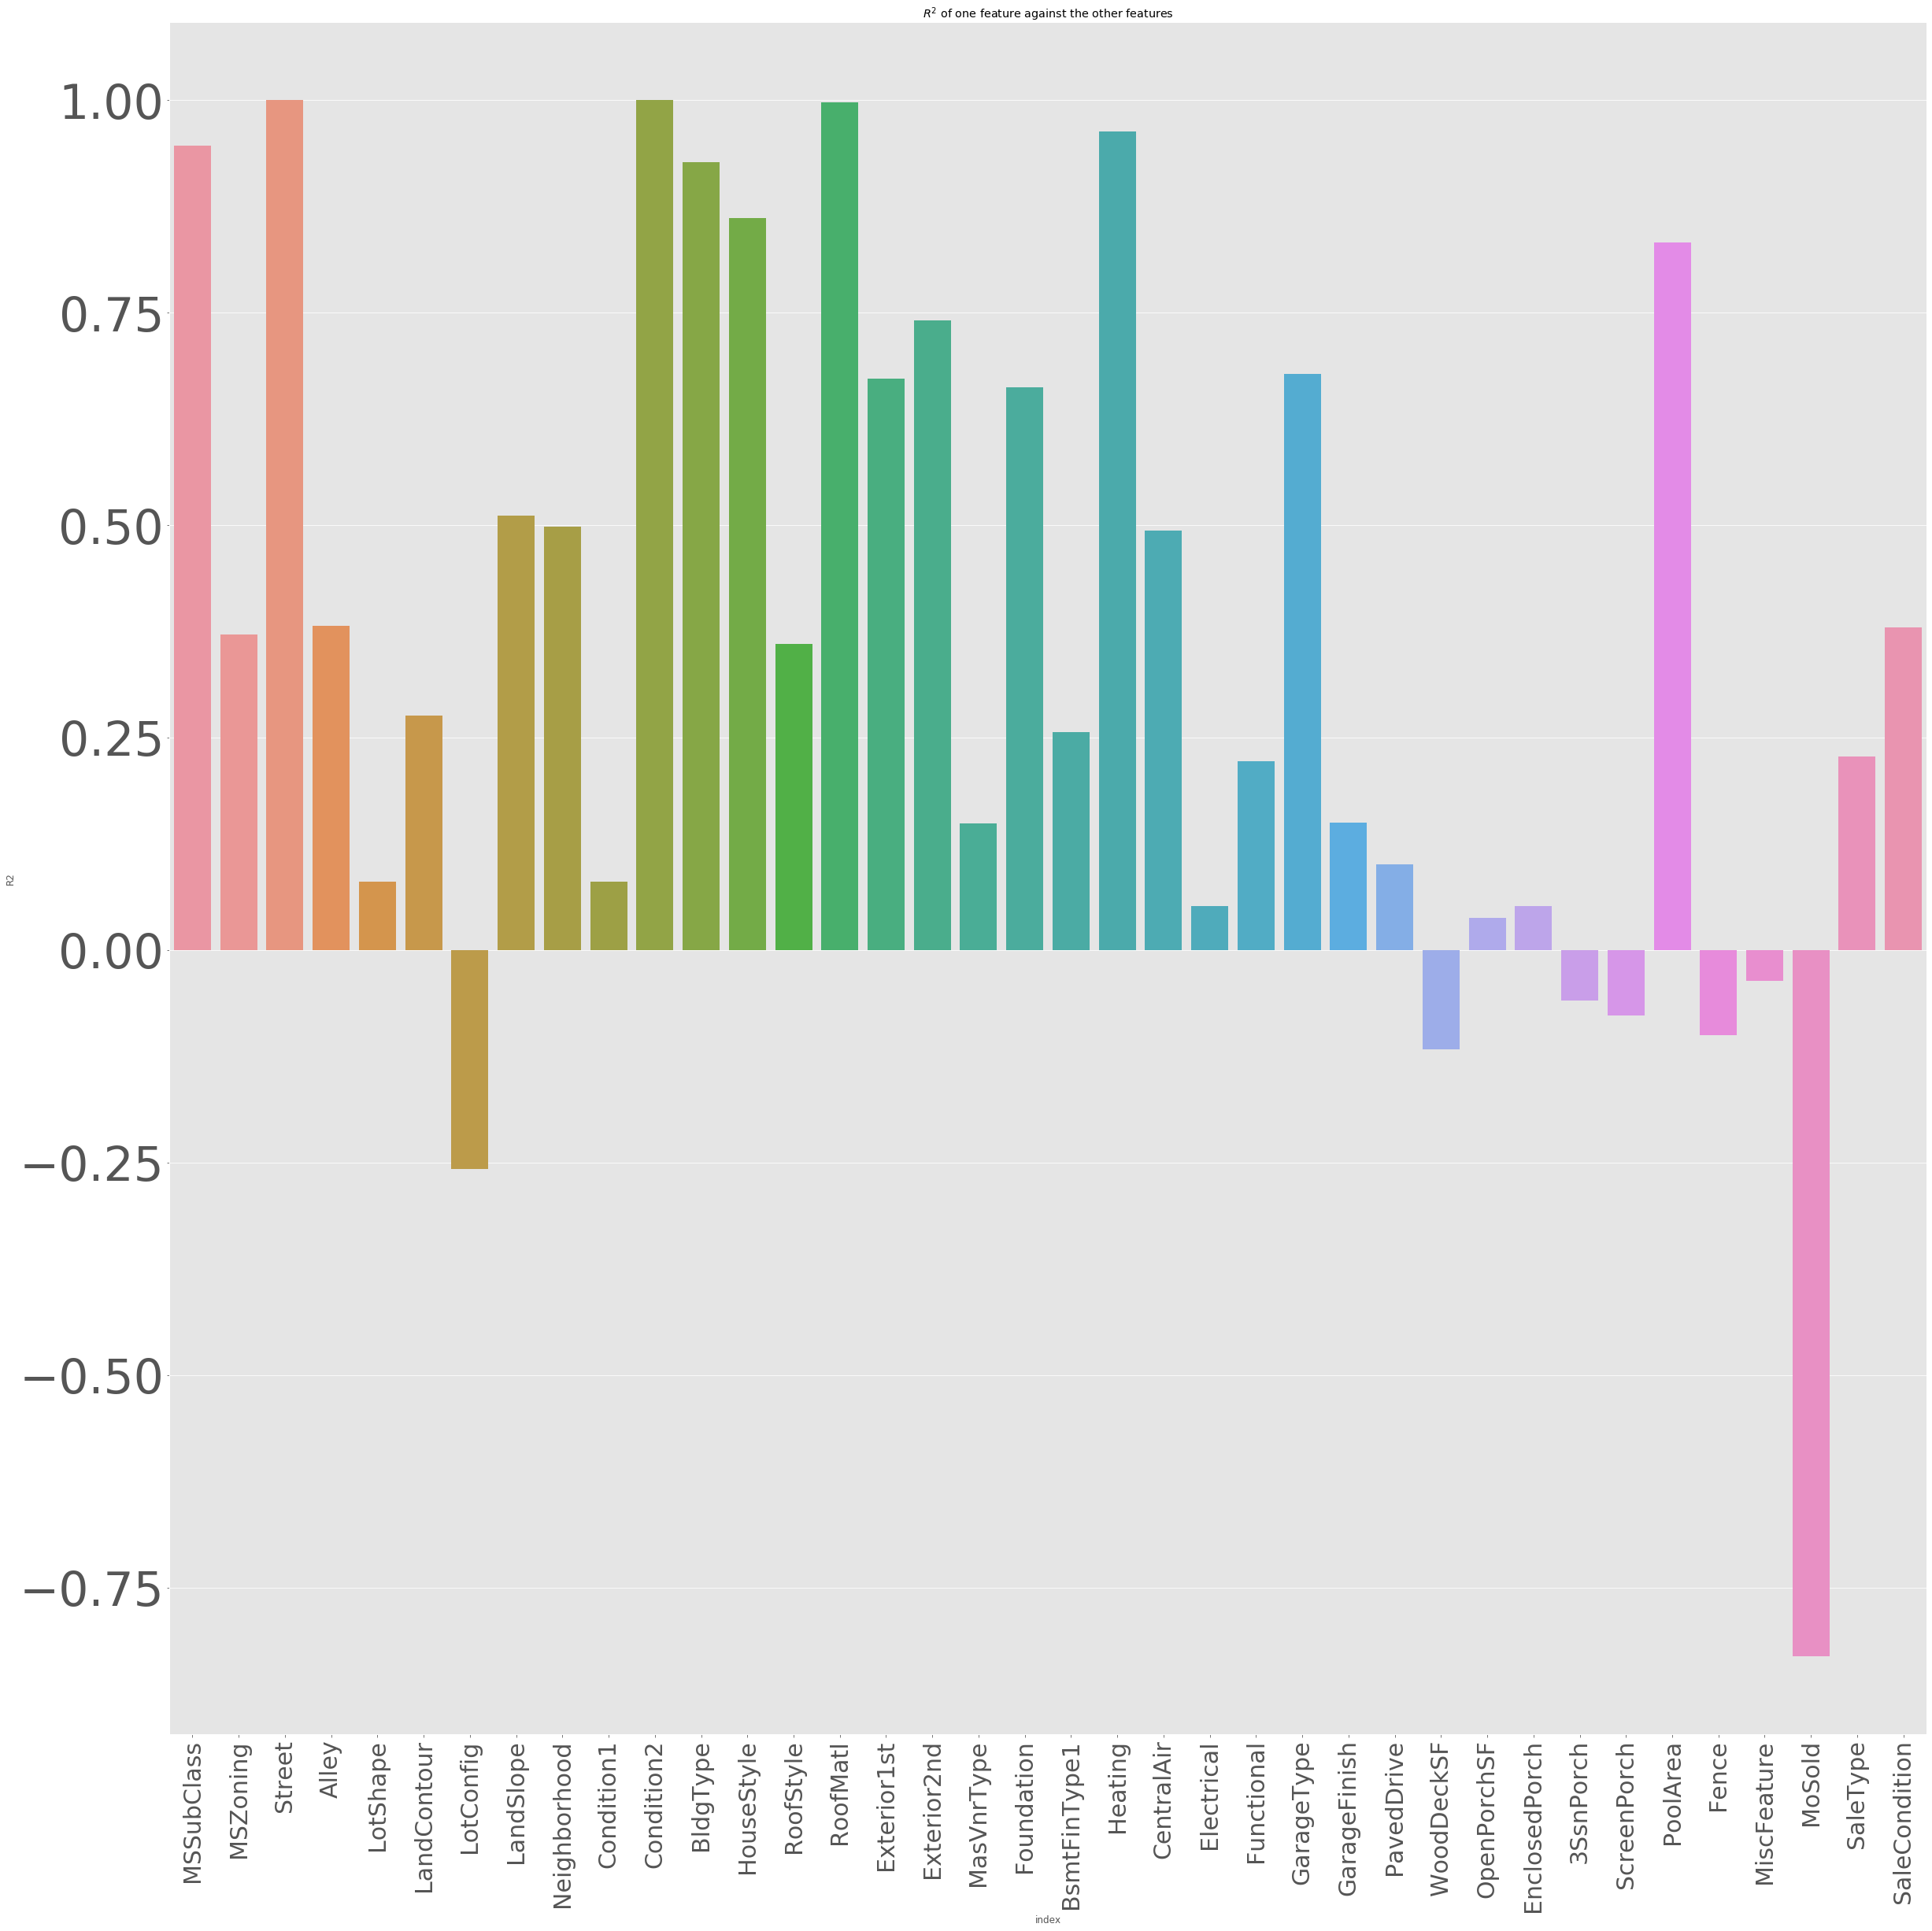

In [10]:
# For umdummified (multiclass) classification
x=cat_df.drop('SalePrice',axis=1)
y=cat_df.SalePrice
# For dummified classification
cat_scores={}
logit=LogisticRegression(C=1e4,solver='liblinear',multi_class='ovr')
cat_cols=x.columns[~x.columns.isin(cont_var_for_tuning)]
for feature in cat_cols:
    x_copy=x.copy()
    feature_col=x_copy[feature].copy()
    x_copy.drop(feature,axis=1,inplace=True)
    logit.fit(x_copy, feature_col)
    cat_scores[feature] = metrics.r2_score(feature_col, logit.predict(x_copy))
plt.figure(figsize=(40,40))
ax=sns.barplot(x='index', y='R2', data=pd.DataFrame(cat_scores, index=['R2']).T.reset_index())
plt.title('$R^2$ of one feature against the other features');
plt.xticks(rotation=90);
plt.yticks(size=60);
plt.xticks(size=30);
# use R^2=0.4 and 0.8 as a cutoff. Below 0.4 is acceptable. Above 0.8 is unacceptable